In [1]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob as gb
%matplotlib inline


In [2]:
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,Concatenate
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from imutils import paths
from sklearn.model_selection import train_test_split

In [3]:
WIDTH=224
HEIGHT=224

In [4]:
train_image = "dataset/train"
test_image = "dataset/test"


print(train_image)
print(test_image)

dataset/train
dataset/test


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [6]:
resnet50 = ResNet50(input_shape=(WIDTH,HEIGHT,3), weights='imagenet', include_top=False)

for layer in resnet50.layers:
  layer.trainable = False

x = resnet50.output
x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)

x = Dense(3, activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:
from keras import backend as K
def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall
def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [8]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      'accuracy','AUC',])
    
train_generator = train_datagen.flow_from_directory(train_image,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_generator = test_datagen.flow_from_directory(test_image,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

start=time.time()
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=30) 
print("training time: %.2f minutes"%((time.time()-start)/60))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
81/81 [==============================] - 375s 5s/step - loss: 1.2206 - precision: 0.6286 - recall: 0.5786 - fbeta_score: 0.6158 - accuracy: 0.6207 - auc: 0.7557 - val_loss: 0.7553 - val_precision: 0.6780 - val_recall: 0.6771 - val_fbeta_score: 0.6778 - val_accuracy: 0.6638 - val_auc: 0.8701
Epoch 2/30
81/81 [==============================] - 361s 4s/step - loss: 0.7234 - precision: 0.7141 - recall: 0.6784 - fbeta_score: 0.7065 - accuracy: 0.6995 - auc: 0.8539 - val_loss: 0.6064 - val_precision: 0.7701 - val_recall: 0.7515 - val_fbeta_score: 0.7662 - val_accuracy: 0.7601 - val_auc: 0.9098
Epoch 3/30
81/81 [==============================] - 362s 4s/step - loss: 0.6807 - precision: 0.7330 - recall: 0.7004 - fbeta_score: 0.7261 - accuracy: 0.7224 - auc: 0.8711 - val_loss: 0.6060 - val_precision: 0.7594 - val_recall: 0.745

Epoch 27/30
81/81 [==============================] - 26734s 330s/step - loss: 0.4692 - precision: 0.8067 - recall: 0.7427 - fbeta_score: 0.7928 - accuracy: 0.7792 - auc: 0.9361 - val_loss: 0.3279 - val_precision: 0.8839 - val_recall: 0.8586 - val_fbeta_score: 0.8769 - val_accuracy: 0.8835 - val_auc: 0.9728
Epoch 28/30
81/81 [==============================] - 368s 5s/step - loss: 0.4580 - precision: 0.8053 - recall: 0.7651 - fbeta_score: 0.7967 - accuracy: 0.7879 - auc: 0.9398 - val_loss: 0.3135 - val_precision: 0.8955 - val_recall: 0.8824 - val_fbeta_score: 0.8927 - val_accuracy: 0.8952 - val_auc: 0.9742
Epoch 29/30
81/81 [==============================] - 361s 4s/step - loss: 0.4554 - precision: 0.8076 - recall: 0.7637 - fbeta_score: 0.7982 - accuracy: 0.7897 - auc: 0.9406 - val_loss: 0.3214 - val_precision: 0.8848 - val_recall: 0.8735 - val_fbeta_score: 0.8822 - val_accuracy: 0.8750 - val_auc: 0.9708
Epoch 30/30
81/81 [==============================] - 359s 4s/step - loss: 0.4483 - p

In [9]:
model.save_weights('resnet50.h5')

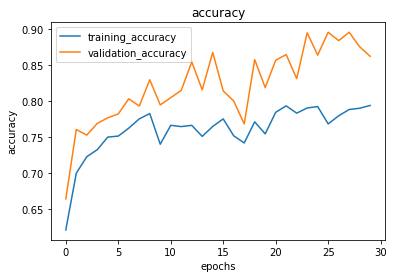

In [10]:
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'],label='training_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.savefig('accuracy_resnet50.png')

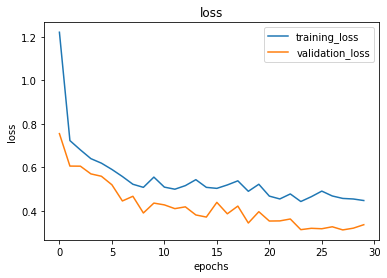

In [11]:
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.savefig('loss_resnet50.png')

In [12]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)

Instructions for updating:
Please use Model.predict, which supports generators.


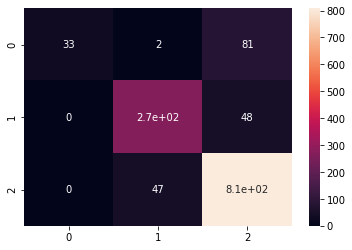

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes,y_pred)
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix_resnet50.png')

In [14]:
tp=cm[0,0]
fp=cm[0,:].sum()- tp
fn=cm[:,0].sum()- tp
tn=cm.sum().sum()-tp-fp-fn
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1_score=(2*precision*recall)/(precision+recall)
acc=cm.trace()/cm.sum()
print("Test Accuracy :", acc)
print("Test Precision :", precision)
print("Test Recall :", recall)
print("Test F1_Score :", f1_score)

Test Accuracy : 0.8618012422360248
Test Precision : 0.28448275862068967
Test Recall : 1.0
Test F1_Score : 0.44295302013422816


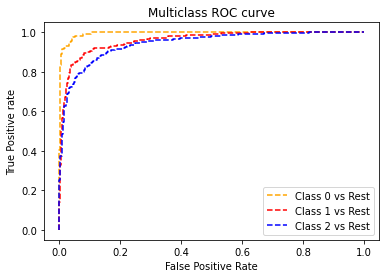

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, Y_pred[:,i], pos_label=i)
       
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    


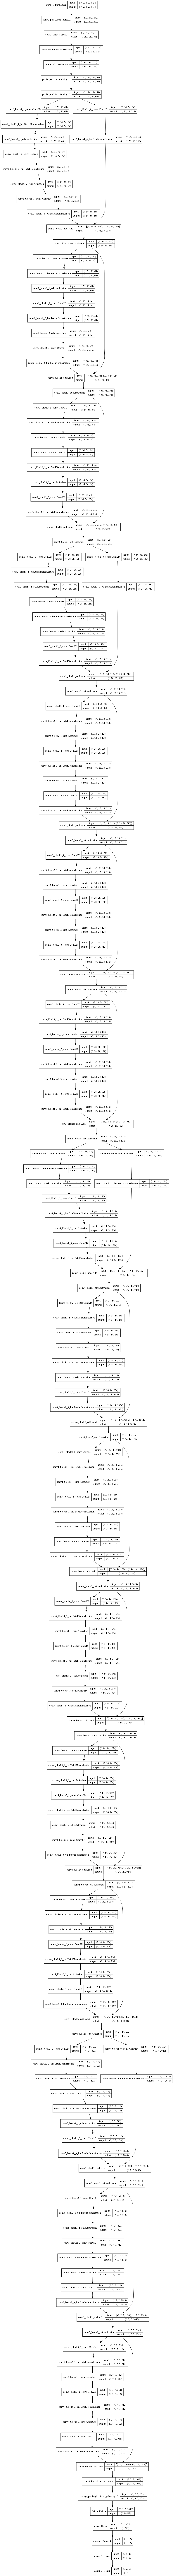

In [16]:
from keras.utils import plot_model
plot_model(model,to_file='resnet50_model.png',show_shapes=True)